In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, max_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [37]:
df_option = pd.read_pickle("MSFT_trainning_master_data.pkl")

In [38]:
df_option.columns

Index(['Target_std', 'Target_spread', 'prior_std', 'prior_Vol', 'prior_spread',
       'prior_range', 'cut_close', 'cut_1hr', 'cut_2hr', 'cut_3hr',
       'vix_prior_std', 'vix_pr_spread', 'vix_prior_range', 'vix_cut_open',
       'vix_cut_1hr', 'vix_cut_2hr', 'vix_cut_3hr', 'tqqq_prior_std',
       'tqqq_Vol', 'tqqq_pr_spread', 'tqqq_prior_range', 'tqqq_cut_open',
       'tqqq_cut_1hr', 'tqqq_cut_2hr', 'tqqq_cut_3hr'],
      dtype='object')

In [39]:
len(df_option.columns)

25

<Axes: >

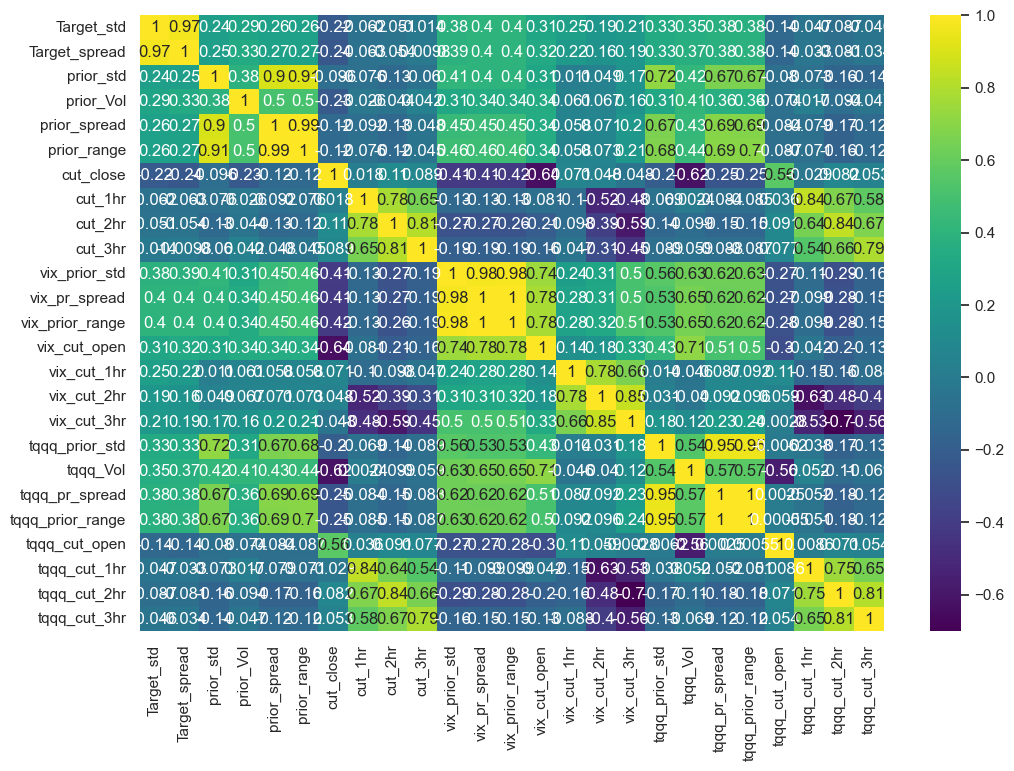

In [40]:
plt.figure(figsize=(12,8))
sns.heatmap(df_option.corr(numeric_only=True),cmap='viridis',annot=True)

<Axes: ylabel='Frequency'>

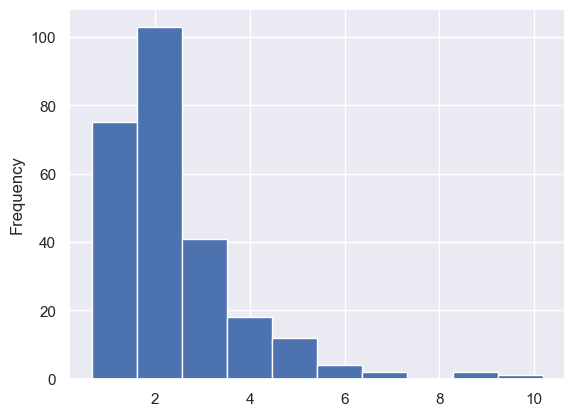

In [41]:
df_option.Target_spread.plot.hist()

In [ ]:
#sns.catplot(x='OP_EXP',y='Target_std',data=df_option, kind='box')

In [42]:
df_option.reset_index(inplace=True)

## Splitting the Data


In [43]:
X = df_option.drop(['Date_Only','Target_std','Target_spread'], axis=1)  
#y = df_option['Target_std']
y = df_option['Target_spread']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [45]:
X_train.columns

Index(['prior_std', 'prior_Vol', 'prior_spread', 'prior_range', 'cut_close',
       'cut_1hr', 'cut_2hr', 'cut_3hr', 'vix_prior_std', 'vix_pr_spread',
       'vix_prior_range', 'vix_cut_open', 'vix_cut_1hr', 'vix_cut_2hr',
       'vix_cut_3hr', 'tqqq_prior_std', 'tqqq_Vol', 'tqqq_pr_spread',
       'tqqq_prior_range', 'tqqq_cut_open', 'tqqq_cut_1hr', 'tqqq_cut_2hr',
       'tqqq_cut_3hr'],
      dtype='object')

In [46]:
X_train.shape

(206, 23)

In [47]:
y_train.shape

(206,)

## Evaluation Run Model with the Data


In [48]:
def run_model(model,X_train,y_train,X_test,y_test):
    
    # Fit Model
    model.fit(X_train,y_train)
    
    # Get Metrics
    
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test,preds)
    print(f'mae : {mae}')
   
    
    plt.figure(figsize=(12,8),dpi=200)
    plt.scatter(y_test, preds)
    plt.plot(y_test, y_test, color='green', linestyle='dashed')
    plt.xlabel('real_std')

    return model

----

## Support Vector Regression

In [49]:
from sklearn.svm import SVR

In [50]:
from sklearn.model_selection import GridSearchCV

In [51]:
scaler = StandardScaler()
sc_X_train = scaler.fit_transform(X_train)
sc_X_test = scaler.transform(X_test)

In [52]:
param_grid = {'C':[0.01,0.1,1,5,10,100,1000],'gamma':['auto','scale']}
svr = SVR()

In [53]:
grid = GridSearchCV(svr,param_grid)

mae : 0.7093374054848406


GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 1, 5, 10, 100, 1000],
                         'gamma': ['auto', 'scale']})

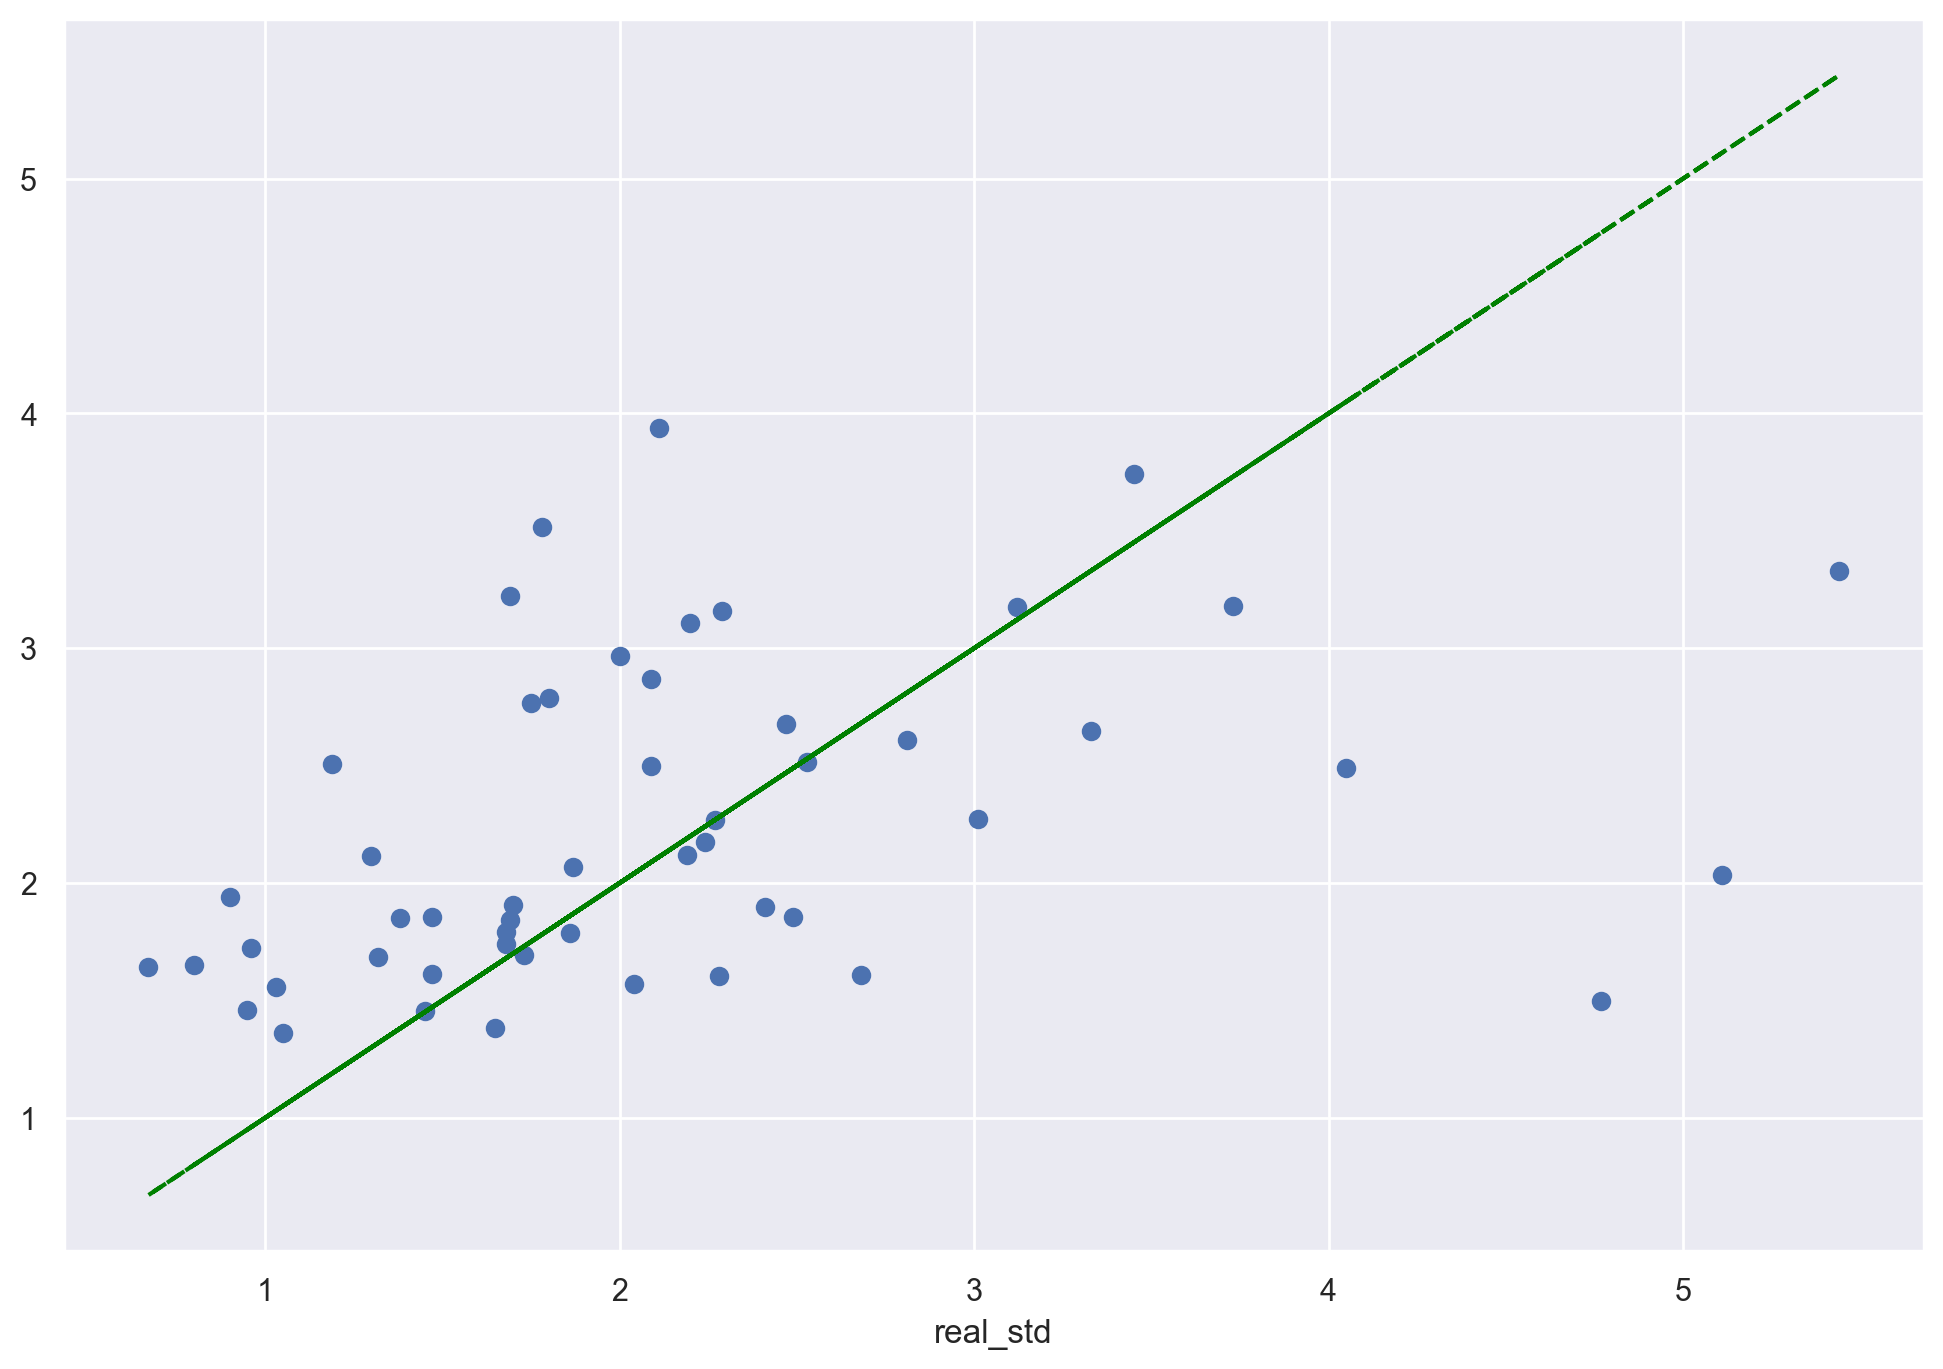

In [54]:
run_model(grid,sc_X_train,y_train,sc_X_test,y_test)

In [25]:
scaler_filename = "scaler4svr_MSFT.save"
joblib.dump(scaler, scaler_filename)

['scaler4svr_MSFT.save']

In [26]:
SVR_model = grid.best_estimator_

In [27]:
filename = 'SVR_model_MSFT.joblib'
joblib.dump(SVR_model, filename)

['SVR_model_MSFT.joblib']

---

## Random Forest Regression

## Gradient Boosting


In [28]:
from sklearn.ensemble import GradientBoostingRegressor

In [29]:
# help(GradientBoostingRegressor)

mae : 0.8589015846697088


GradientBoostingRegressor()

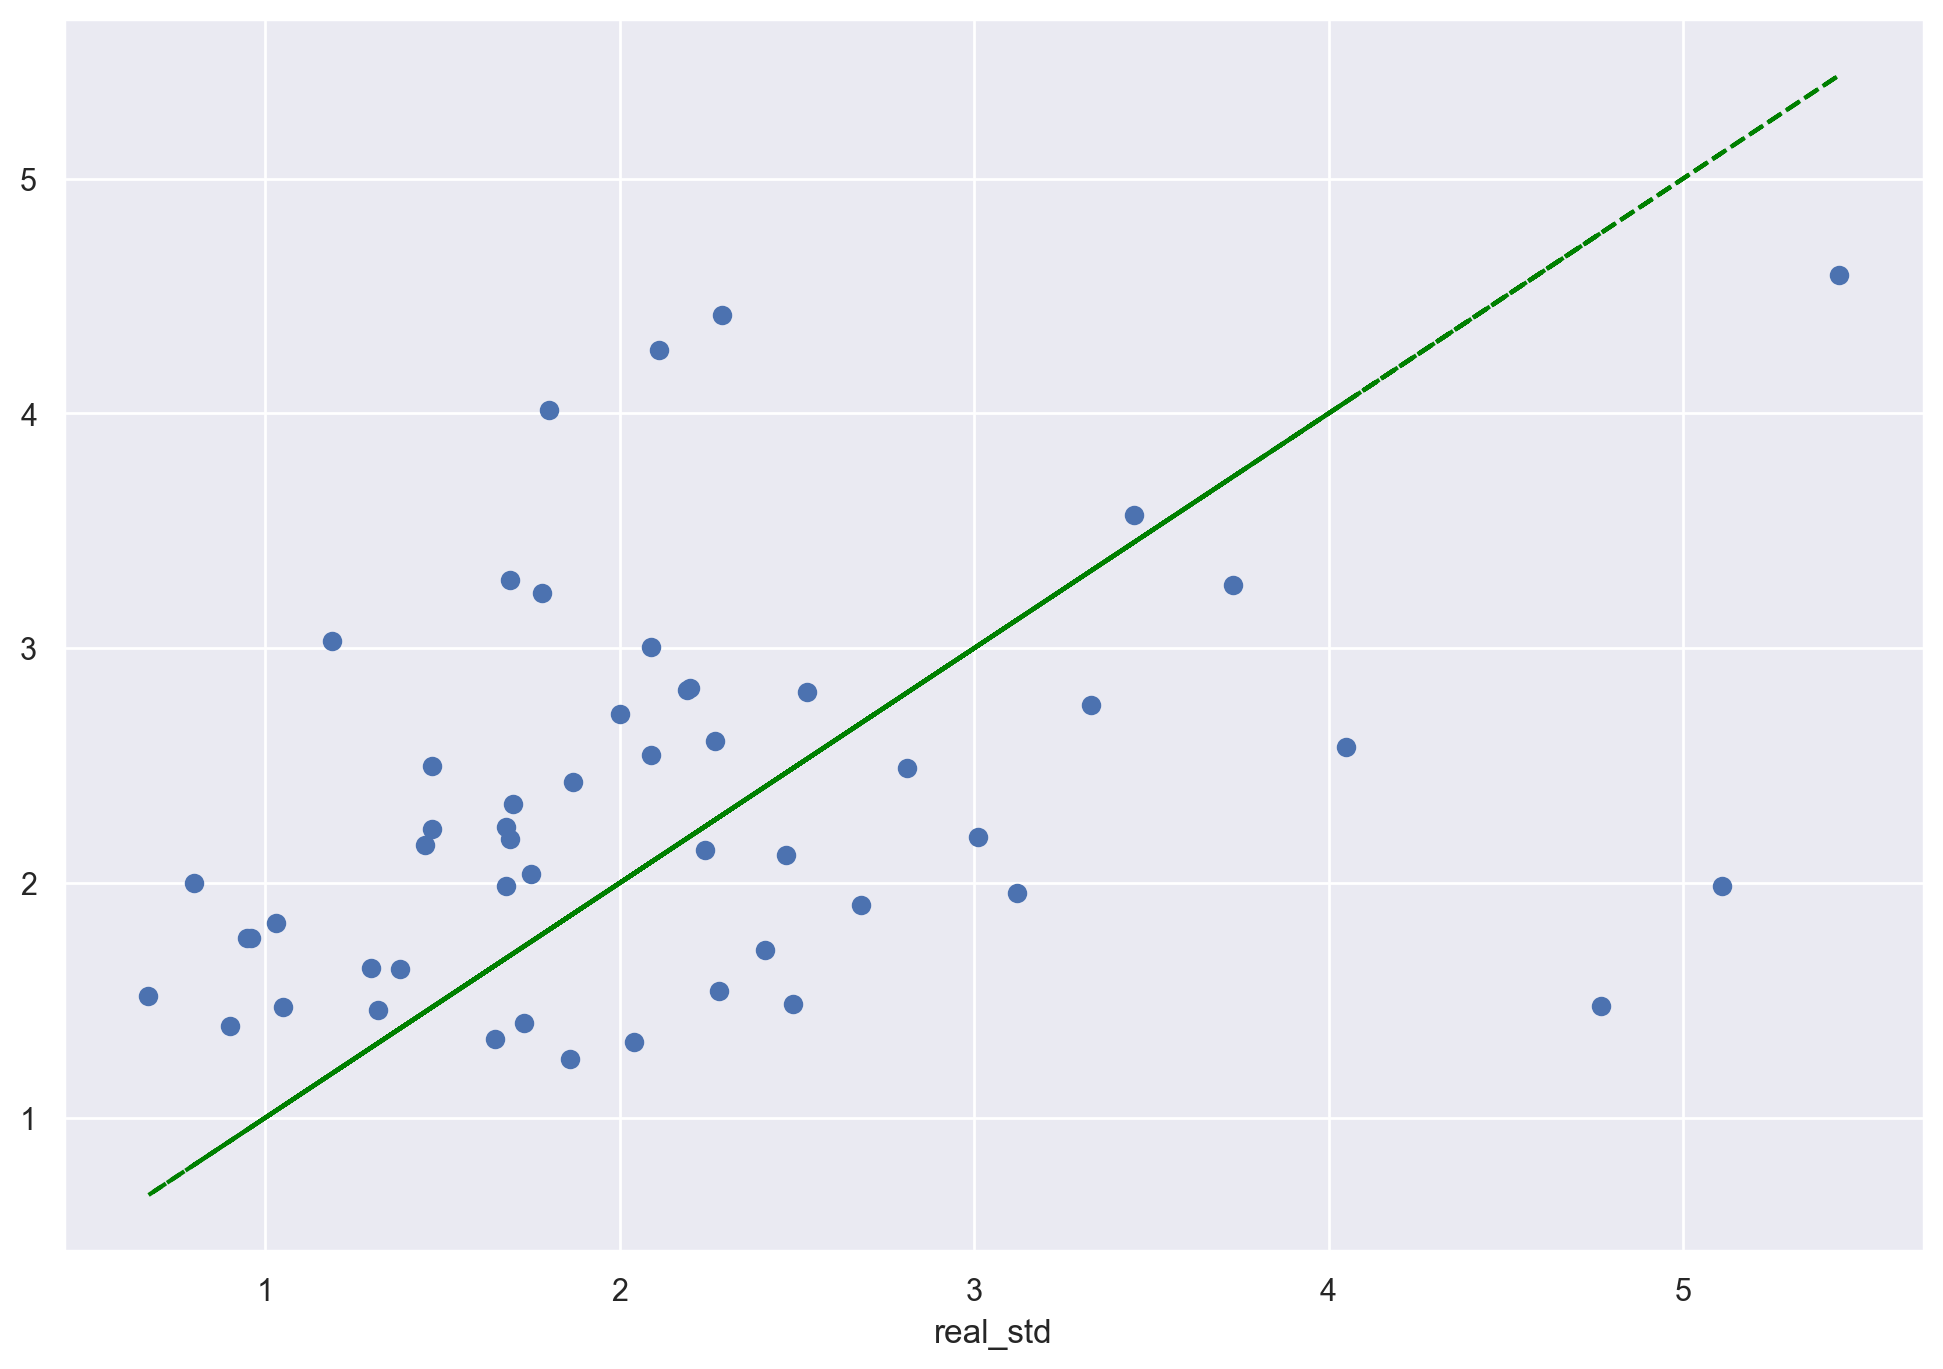

In [30]:
   
model = GradientBoostingRegressor()

run_model(model,X_train,y_train,X_test,y_test)

In [62]:
import xgboost as xgb
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8]
}

# Initialize XGBoost regressor
xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgbr,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=10,
                           verbose=0,
                          n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", np.sqrt(-grid_search.best_score_))

# Evaluate the best model on the test set
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", rmse)

Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.7}
Best score: 1.2345583802538582
Test RMSE: 1.0642429670965525


mae : 0.8383396940964911


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

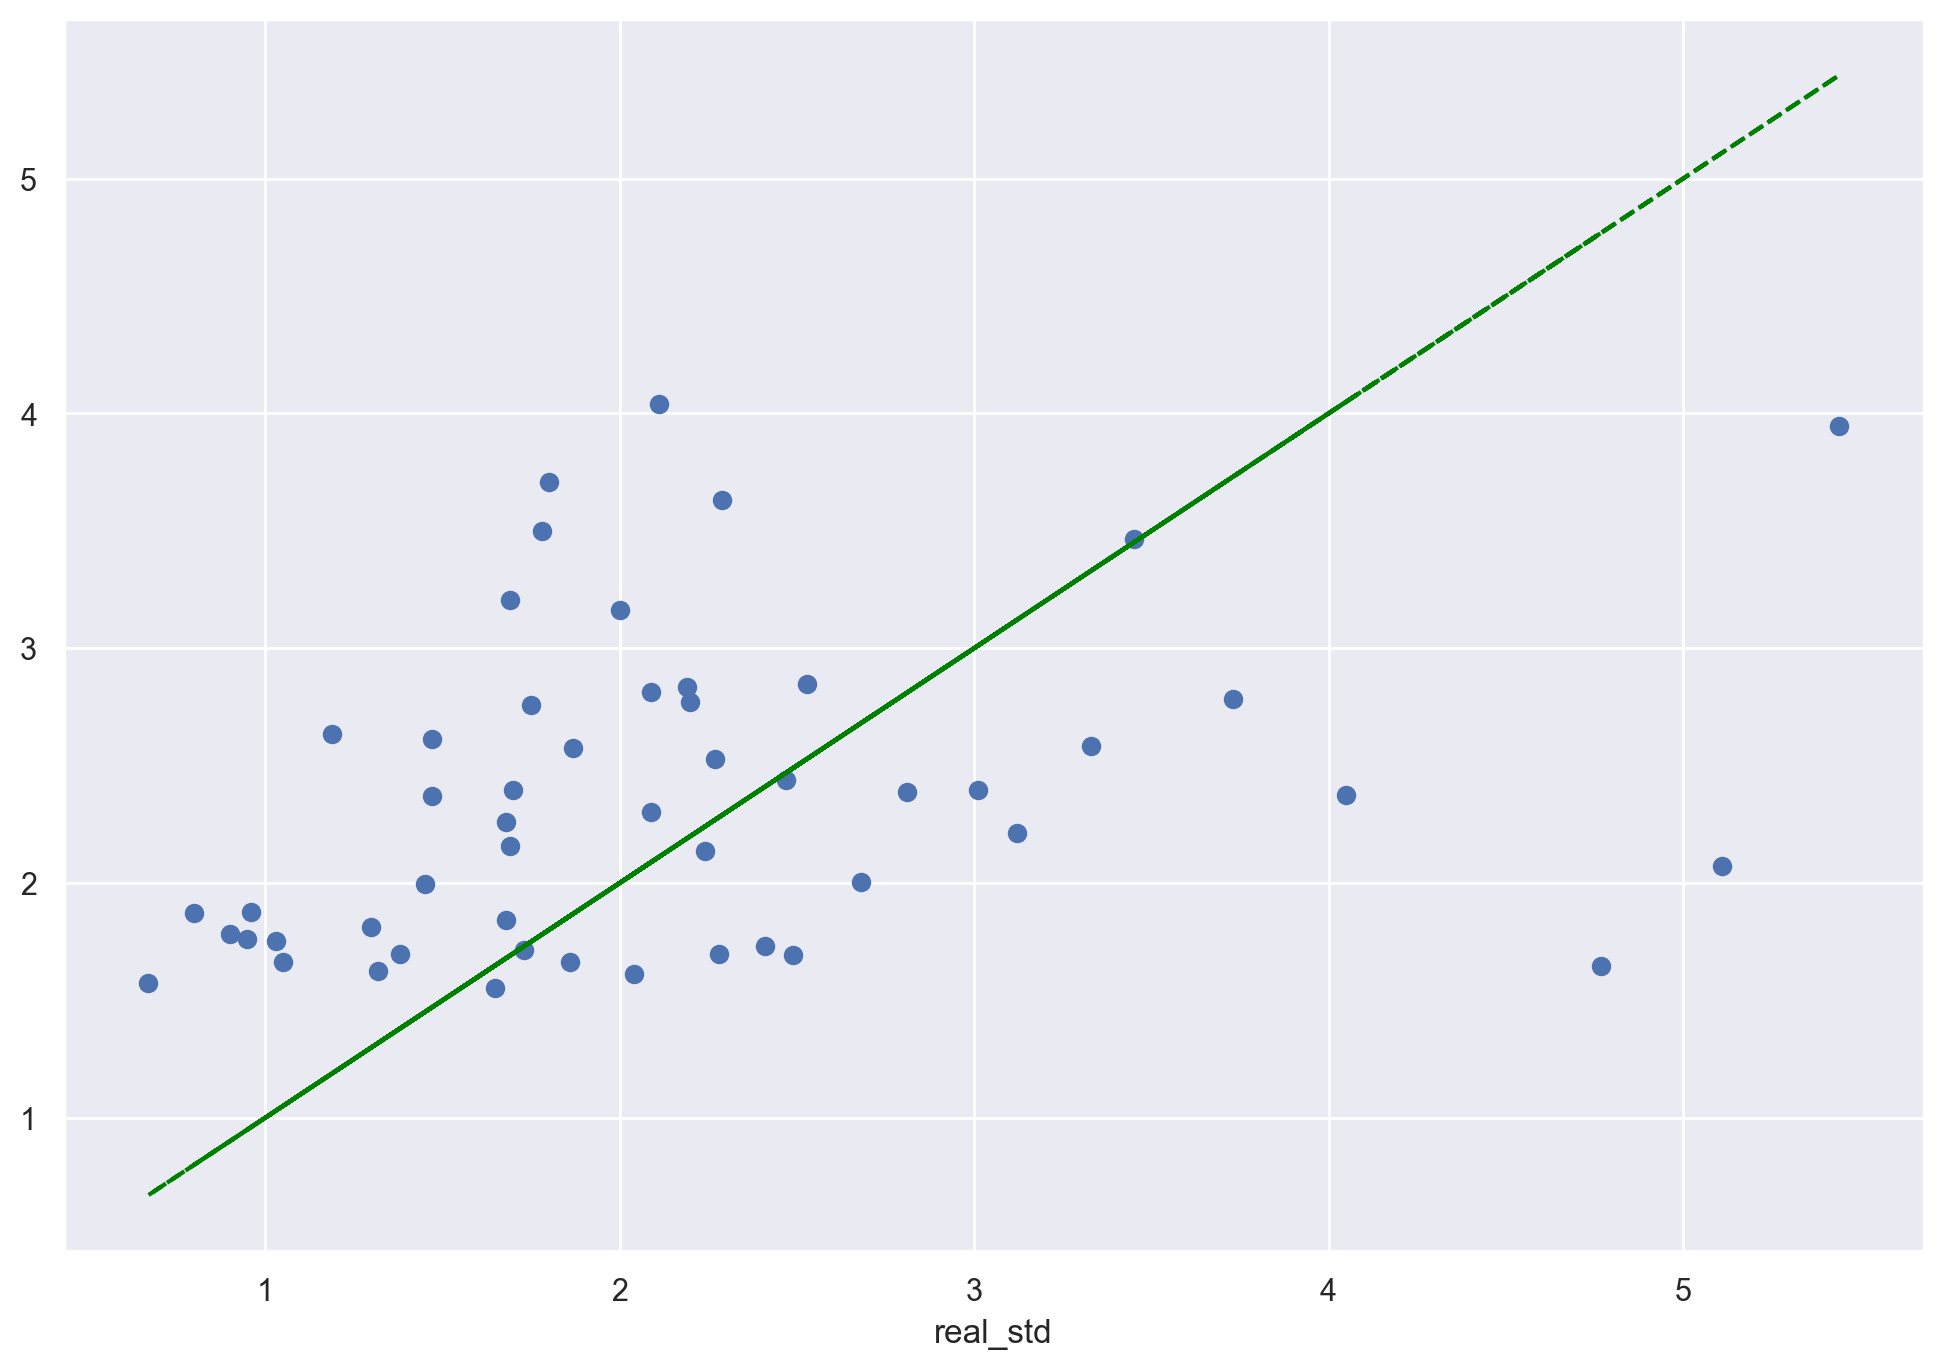

In [63]:
run_model(best_xgb_model,X_train,y_train,X_test,y_test)

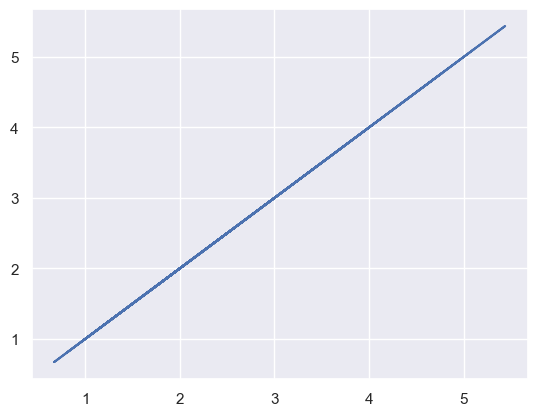

In [55]:
plt.plot(y_test, y_test)

In [64]:
pd.DataFrame(index=X.columns,data=best_xgb_model.feature_importances_,columns=['Feature Importance'])

,Feature Importance
prior_std,0.018990
prior_Vol,0.032822
prior_spread,0.023633
prior_range,0.029128
cut_close,0.040763
cut_1hr,0.018262
cut_2hr,0.018691
cut_3hr,0.027618
vix_prior_std,0.035792
vix_pr_spread,0.077945


In [65]:
X_train

,prior_std,prior_Vol,prior_spread,prior_range,cut_close,cut_1hr,cut_2hr,cut_3hr,vix_prior_std,vix_pr_spread,...,vix_cut_2hr,vix_cut_3hr,tqqq_prior_std,tqqq_Vol,tqqq_pr_spread,tqqq_prior_range,tqqq_cut_open,tqqq_cut_1hr,tqqq_cut_2hr,tqqq_cut_3hr
160,1.394721,21235.050000,6.01,6.01,425.17,0.47,0.68,-0.27,0.086280,0.39,...,0.06,0.10,0.458900,100680.670000,2.17,1.94,82.17,0.15,0.07,0.35
196,0.928397,16909.223333,4.20,4.22,423.51,0.77,2.34,2.09,0.254181,1.00,...,-0.12,-0.47,0.772075,108178.683333,3.01,3.01,82.68,0.34,0.94,1.18
159,1.364279,32650.583333,8.52,8.66,418.92,1.83,3.08,3.02,0.109793,0.57,...,0.21,0.20,0.615096,125054.770000,2.35,2.40,78.75,0.26,0.90,1.15
132,0.865283,11260.423333,3.68,3.66,425.92,-1.72,-2.86,-2.10,0.206583,1.20,...,0.05,0.41,0.361032,87239.236667,2.04,2.03,70.57,-0.90,-1.54,-1.45
80,1.256585,26528.103333,5.33,5.31,444.12,2.17,3.55,2.79,0.264705,0.93,...,-0.49,-0.45,0.760235,149569.536667,3.14,3.13,74.95,0.14,0.25,-0.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2.086341,27381.466667,8.97,8.94,435.37,0.40,1.26,-0.51,0.356890,1.37,...,0.21,0.43,0.657840,121637.556667,2.59,2.58,66.35,-0.18,-0.31,-1.06
113,2.657340,18165.880000,10.68,10.74,409.43,-2.38,-2.23,-4.06,0.723542,2.36,...,1.85,2.04,1.011001,156050.910000,4.66,4.47,62.62,-1.36,-1.32,-1.64
64,0.785620,37628.713333,3.61,3.68,449.25,0.71,-0.27,1.59,0.106536,0.48,...,-0.08,0.06,0.382451,89904.873333,1.71,1.73,74.69,0.27,-0.54,0.01
15,1.614641,21496.483333,6.45,6.43,428.87,1.51,3.00,4.46,0.490358,1.63,...,-0.23,-0.80,0.798640,170290.956667,3.05,3.05,61.83,0.78,1.91,2.37


In [66]:
import joblib
# Assuming 'model' is your trained model object
filename = 'xgb_model_MSFT_price_spread_update.joblib'
joblib.dump(best_xgb_model, filename)


['xgb_model_MSFT_price_spread_update.joblib']

In [67]:
pwd

'C:\\Users\\jepar\\PycharmProjects\\Option_Play\\Prod\\MSFT'

----